[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QbxLJz7dDIL4BOG1yaVlum-fndTScgQe#scrollTo=cC6aMn2G-UAD)

In [ ]:
#Subir credenciales de kaggle , en tu cuenta de kaggle ve a settings -> Create Token 
#Se descargara un archivo .json con tus credenciales
#Ese archivo es el que debes subir en este comando
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipevasquezu","key":"eb7b2c1020732009b3b57f08a0eacbb3"}'}

#**Descargar Datos desde Kaggle**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c store-sales-time-series-forecasting


100% 21.4M/21.4M [00:01<00:00, 32.1MB/s]
100% 21.4M/21.4M [00:01<00:00, 20.1MB/s]


In [ ]:
! unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [ ]:
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

In [ ]:
path=''

# **Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px 

In [ ]:
path=''
# Load train
train_df = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_df = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
store_df = pd.read_csv(path+'stores.csv')
#Load oil 
oil_df = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_df= pd.read_csv(path+'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Load transactions
transaction_df = pd.read_csv(path+'transactions.csv', parse_dates=['date'], infer_datetime_format=True)

# **ANALISIS**

## **Train**

In [ ]:
# Cuantas tiendas , productos y fechas hay en el dataset

print('Stores : ',train_df['store_nbr'].unique().__len__()) # 54 stores
print('Families : ',train_df['family'].unique().__len__()) # 33 products

print('Dias en train data : ',len(train_df) / 54 / 33) # 1684 days (between 4 and 5 years)
print('Fecha Inicial Train : ',train_df['date'].iloc[0]) # 2013-01-01 is start
print('Fecha Final Train : ',train_df['date'].iloc[-1]) # 2017-08-15 is end

print('Dias en test data : ',len(test_df) / 54 / 33) # 16 days
print('Fecha Inicial Test : ',test_df['date'].iloc[0]) # 2017-08-16 is test start
print('Fecha Final Test : ',test_df['date'].iloc[-1]) # 2017-08-31 is test test_df

print('Registros totales en train : ',train_df['id'].unique().__len__())
print('Registros totales en Test : ',test_df['id'].unique().__len__())

Stores :  54
Families :  33
Dias en train data :  1684.0
Fecha Inicial Train :  2013-01-01 00:00:00
Fecha Final Train :  2017-08-15 00:00:00
Dias en test data :  16.0
Fecha Inicial Test :  2017-08-16 00:00:00
Fecha Final Test :  2017-08-31 00:00:00
Registros totales en train :  3000888
Registros totales en Test :  28512


Podemos observar que tanto los datos en Train como Test se distribuyen de la siguiente manera : 
Tenemos 33 familias de productos , en 54 tiendas con un registro de ventas en 1684 dias (desde la fecha inicial hasta la fecha final del dataset ) , esto es 33*54*1684 = 3000888 registros .
Cada registro representa la venta de un producto (familia) en una tienda especifica (store_nbr) en un dia (date) , los datos estan entre 2013-2017

In [ ]:
data = train_df.copy()
data = data.set_index("date").to_period('D')
data = data.groupby('date').agg({'sales':'mean'})
#Grafica interactiva 
data =data.iloc[1:, :].reset_index()
data['date']=data['date'].apply(lambda x: x.to_timestamp())
# data

fig = px.line(
    data_frame = data,
    x      = 'date',
    y      = 'sales', 
    title  = 'Ventas diarias',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

La grafica anterior de ventas diaras , nos da un indicio de que hay un patron de ventas dependiendo del los dias

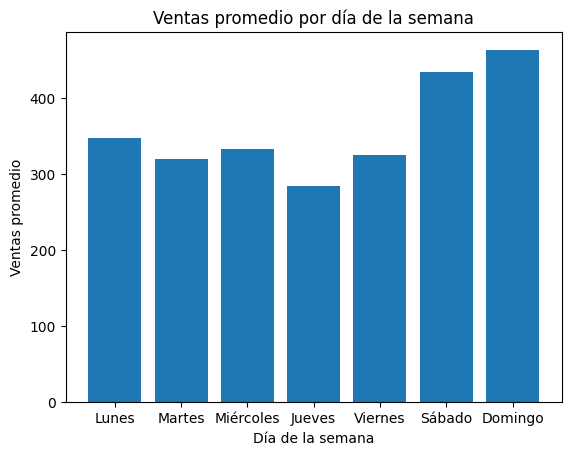

In [ ]:
data = train_df.copy()
data['day_of_week'] = data['date'].dt.weekday
sales_by_day = data.groupby('day_of_week')['sales'].mean()

# Crear un gráfico de barras para visualizar las ventas por día de la semana
plt.bar(sales_by_day.index, sales_by_day.values)
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.title('Ventas promedio por día de la semana')
plt.show()

por lo general los fines de semana son los dias de mas ventas , lo que indica que una buena caracteristica por añadir al dataset podria ser el dia de la semana 

## Stores 

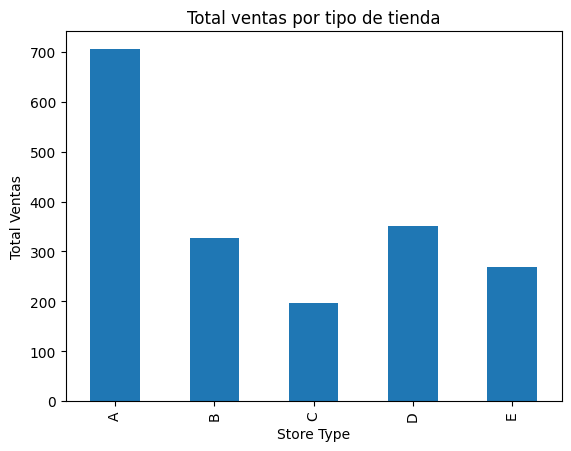

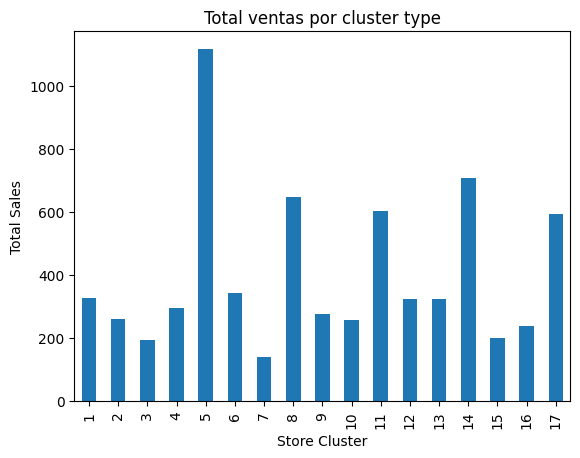

In [ ]:
#Grafica relacion entre stores y train
data = pd.merge(train_df, store_df, on='store_nbr', how='left')
sales_by_type = data.groupby(['type'])['sales'].mean()
sales_by_type.plot(kind='bar')
plt.xlabel('Store Type')
plt.ylabel('Total Ventas')
plt.title('Total ventas por tipo de tienda')
plt.show()
sales_by_cluster = data.groupby('cluster')['sales'].mean()
sales_by_cluster.plot(kind='bar')
plt.xlabel('Store Cluster')
plt.ylabel('Total Sales')
plt.title('Total ventas por cluster type')
plt.show()

Se observa una fuerte relacion entre las tiendas y el promedio de ventas , dado que esto puede afectar en la prediccion se tendra en cuenta los datos de stores , para esto combinamos los dataframe para tener ambos datos, se hace el mismo proceso con test  

## Oil

Correlation with Daily Oil Prices
-0.07905016021992754 



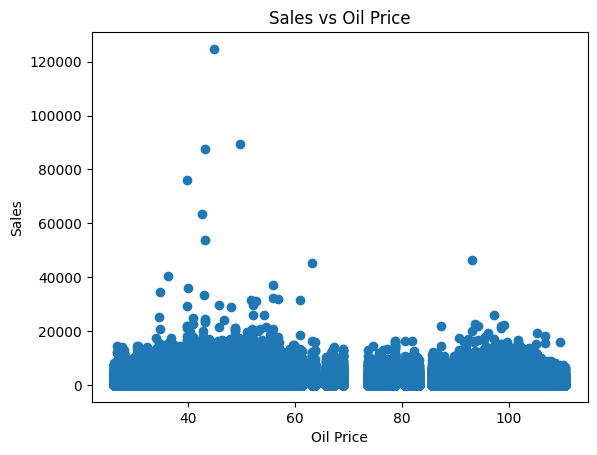

In [ ]:

merged = pd.merge(train_df, oil_df, on='date', how='left')

print("Correlation with Daily Oil Prices")
print((merged['dcoilwtico']).corr(merged["sales"]), "\n")

# Create scatter plot of sales versus oil price
plt.scatter(merged['dcoilwtico'], merged['sales'])
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Sales vs Oil Price')
plt.show()

Se tiene una correlacion entre las ventas diarias y el precio del petroleo de (-0.079), al ser negativo indica que las ventas diarias desminuyen cuando el precio del petroleo aumenta pero no es una relacion fuerte , es importante mirar esta correlacion cuando se busca predecir las ventas promedio por dia y tienda que es realmente nuestra variable a predecir 


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 0, 'Lags')

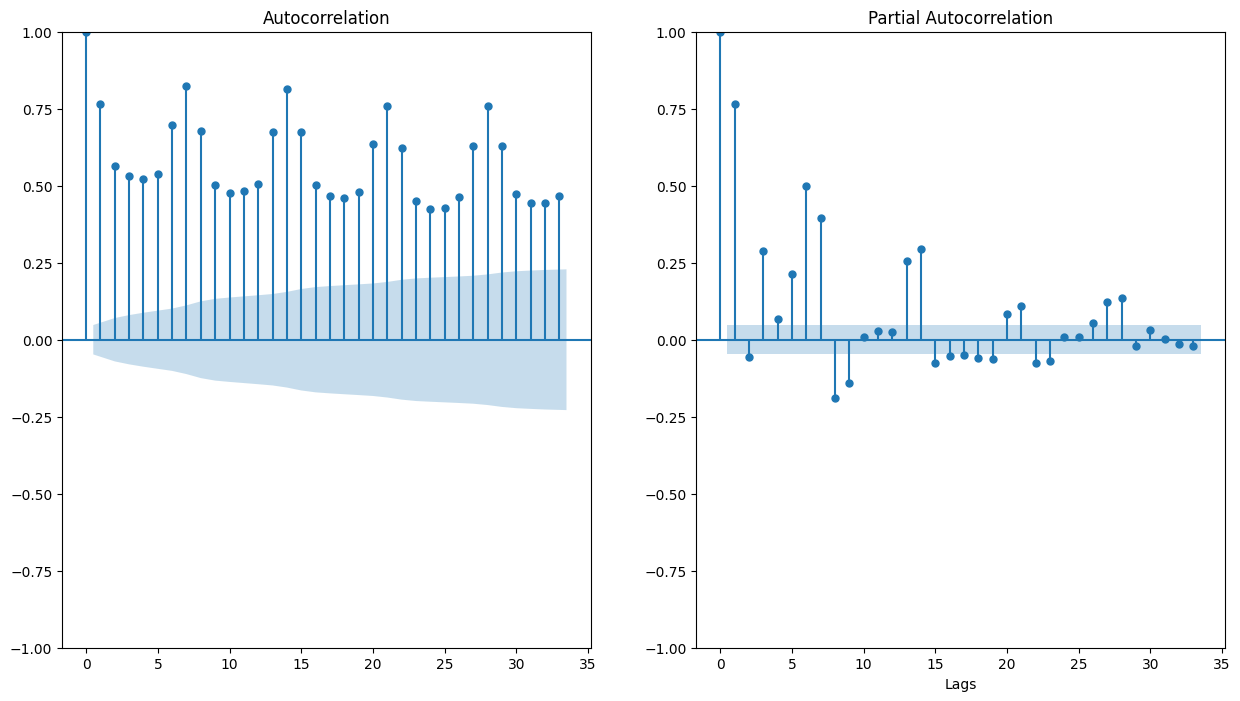

In [ ]:
auto_corr_graph = train_df[['date','sales']].set_index('date')
auto_corr_graph = auto_corr_graph.groupby('date').mean()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
aut1 = plot_acf(auto_corr_graph['sales'],ax=ax[0])
plt.xlabel('Lags')
aut2 = plot_pacf(auto_corr_graph['sales'],ax=ax[1])
plt.xlabel('Lags')

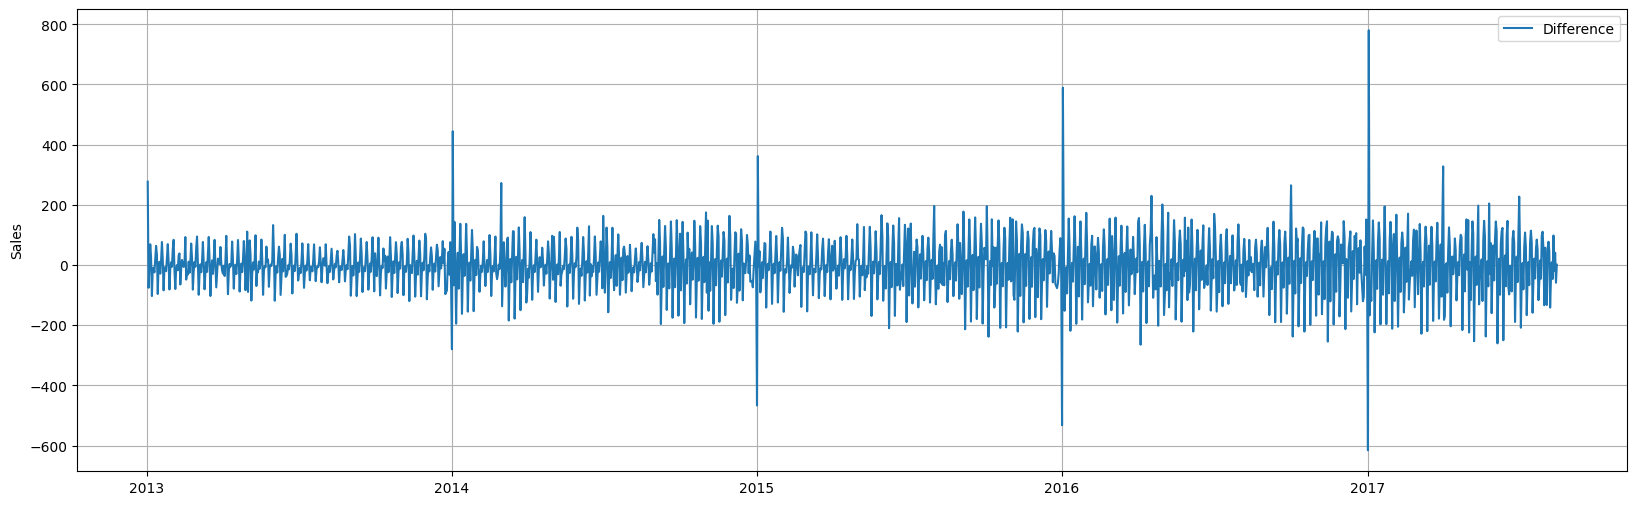

In [ ]:
#making data stationary 
diff = auto_corr_graph['sales'].diff()
plt.figure(figsize=(20,6))
plt.plot(auto_corr_graph.index,diff)
plt.legend(['Difference'])
plt.ylabel('Sales')
plt.grid()
plt.show()

Text(0.5, 0, 'Lags')

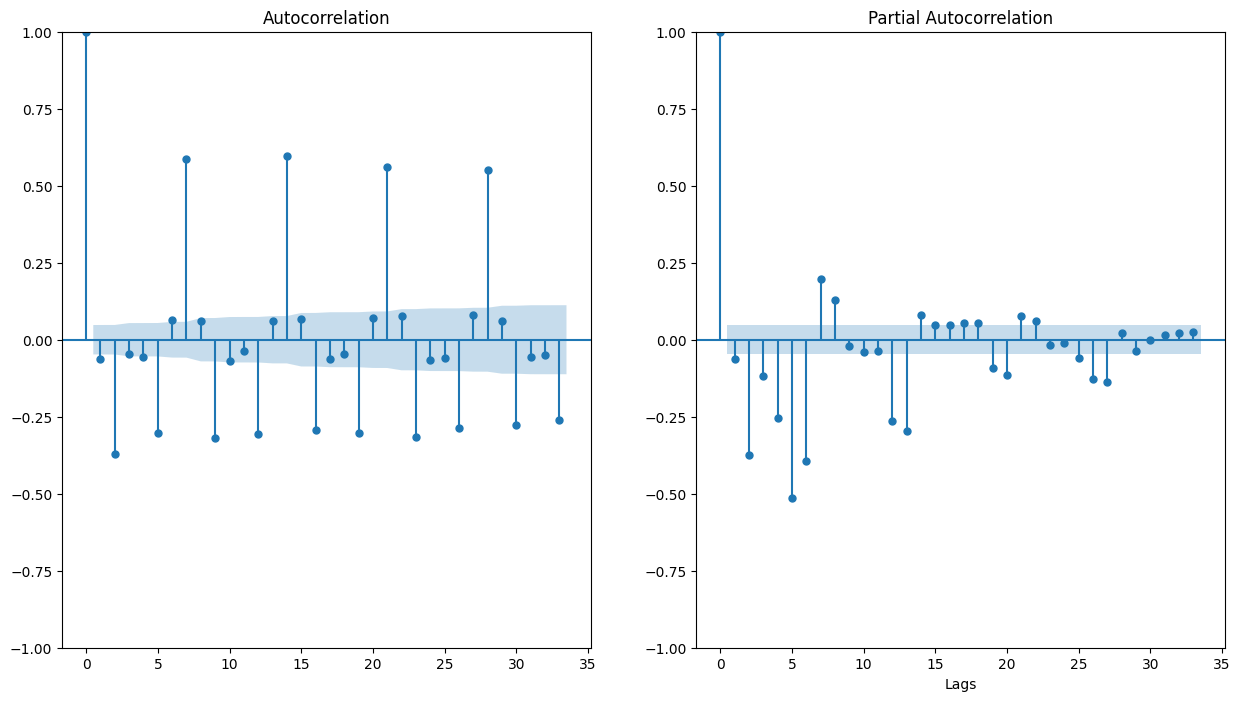

In [ ]:
diff.dropna(inplace=True) #Dropping missing values before computing ACF and PACF
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
aut1 = plot_acf(diff,ax=ax[0])
plt.ylim(-0.75, 1.1)
plt.xlabel('Lags')
aut2 = plot_pacf(diff,ax=ax[1])
plt.xlabel('Lags')
#plt.ylim(-0.75, 1.1)
#Seasonality of 7 lags

In [ ]:
merged = pd.merge(train_df, oil_df, on='date')

# Select the sales and oil price columns
selected_columns = ['sales', 'dcoilwtico']
data = merged[selected_columns]

# Calculate the correlation coefficient
corr_coef = data.corr()['sales']['dcoilwtico']

print('Correlation coefficient between sales and oil price:', corr_coef)



Correlation coefficient between sales and oil price: -0.07905016021992892


Oil price tiene una correlacion negativa con sales , 
lo que significa que cuando el precio del petroleo aumenta , las ventas disminuyen, esta correlacion aumentaria si a añadimos lags para los precios del petrolio N dias antes ?

In [ ]:
merged_data = pd.merge(train_df, oil_df, on='date', how='left')
merged_data = merged_data.drop(index=0).reset_index(drop=True)
merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(merged_data['dcoilwtico'].rolling(3, min_periods=1).mean())

num_of_lags=30
for i in range(1,num_of_lags ):
    merged_data[f'lagged_oil_price_{i}'] = merged_data['dcoilwtico'].shift(i)

# Drop rows with missing values due to the lags
merged_data.dropna(inplace=True)

# Reset the index of the merged data
merged_data.reset_index(inplace=True)

# Select only the relevant columns (date, sales, lags of sales, current oil price, and lagged oil prices)
selected_cols = ['date', 'sales']
# for i in range(1, 8):
#     selected_cols.append(f'sales_lagged_{i}')
selected_cols.append('dcoilwtico')
for i in range(1, num_of_lags):
    selected_cols.append(f'lagged_oil_price_{i}')

selected_data = merged_data[selected_cols]
selected_data
# merged_data

,date,sales,dcoilwtico,lagged_oil_price_1,lagged_oil_price_2,lagged_oil_price_3,lagged_oil_price_4,lagged_oil_price_5,lagged_oil_price_6,lagged_oil_price_7,...,lagged_oil_price_20,lagged_oil_price_21,lagged_oil_price_22,lagged_oil_price_23,lagged_oil_price_24,lagged_oil_price_25,lagged_oil_price_26,lagged_oil_price_27,lagged_oil_price_28,lagged_oil_price_29
0,2013-01-02,47.000,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,...,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14
1,2013-01-02,0.000,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,...,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14
2,2013-01-02,0.000,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,...,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14
3,2013-01-02,38.029,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,...,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14
4,2013-01-02,3.000,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,...,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14,93.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065736,2017-08-15,438.133,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,...,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57
2065737,2017-08-15,154.553,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,...,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57
2065738,2017-08-15,2419.729,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,...,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57
2065739,2017-08-15,121.000,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,...,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57,47.57


In [ ]:
# Calculate the correlation coefficient
corr_matrix = selected_data.corr()

corr_coeff=0.0;
number_of_lags=28
for i in range(1,number_of_lags):
  corr_coeff=corr_coeff+corr_matrix.loc['sales',f'lagged_oil_price_{i}'] 

corr_coeff=corr_coeff/number_of_lags

print('Correlation coefficient between sales and oil price:', corr_coeff)

#No hay correlacion en precios del dolar de dias anteriores 

<ipython-input-19-9a70229326f9>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Correlation coefficient between sales and oil price: -0.07627651575110264
